## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [9]:
def angle(e):
    return 0.205/(e0*2e-3-0.732) + 0.14

def get_x(df, phi):
    mKs= 497.6
    p = phi
#     p = phi(df.ksminv**2 + df.ksptot**2)
    p0 = np.sqrt(df.emeas.mean()**2 - mKs**2)
    dE = df.ksminv - mKs
    dP = df.ksptot - p0
    x1 =  dE*np.cos(p) - dP*np.sin(p)
    x2 =  dE*np.sin(p) + dP*np.cos(p)
    return x1, x2

In [4]:
dfExp = uproot.open('../trees/19/exp.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj.root')['t'].pandas.df()

dfExp['ebeam'] = dfExp.name.astype(str).str.extract(r'_e(\d+.?\d*)_', expand=False).astype(float)
dfMC['ebeam'] = dfMC.name.astype(str).str.extract(r'_(\d+.?\d*)_', expand=False).astype(float)
dfMC['runnum'] = dfMC.name.astype(str).str.extract(r'_(\d+).root', expand=False).astype(int)

dfExp.drop('name', axis=1, inplace=True)
dfMC.drop('name', axis=1, inplace=True)

dfExp = dfExp.set_index('ebeam')
dfMC = dfMC.set_index('ebeam')

In [5]:
dfMC.head()

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],sim_energy
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,70914,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,-1.844756,...,20,9,499.395172,216.374481,0.999027,2.772172,2.506677,143.521515,314.479004,9.248684e-26
537.5,70914,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,0.329661,...,20,13,505.448303,115.481873,0.993188,1.221455,2.907485,164.295303,268.825165,5.417330e-02
537.5,70914,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,0.497540,...,21,16,497.253052,201.719330,0.996737,0.513309,2.246198,207.977081,249.795624,3.772817e-04
537.5,70914,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,-0.814446,...,16,17,497.766693,194.066284,0.999999,0.949363,2.265730,238.261139,217.142105,2.066458e-10
537.5,70914,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,0.318320,...,15,11,496.693756,116.323097,0.992242,0.680561,2.624372,234.139633,192.224991,5.535079e-02


In [6]:
for i in sorted( dfExp.index.unique() & dfMC.index.unique()):
    print(i, end=' ')

537.5 550.0 562.5 575.0 587.5 600.0 612.5 625.0 637.5 641.0 650.0 662.5 675.0 687.5 700.0 712.5 725.0 737.5 750.0 762.0 775.0 787.5 800.0 812.5 825.0 837.5 850.0 862.5 875.0 887.5 900.0 912.5 925.0 936.0 945.0 950.0 951.1 955.0 962.5 975.0 978.0 987.5 

In [85]:
e0, nMC = 850.0, 20000

In [86]:
dfE = dfExp.loc[e0].copy()
dfM =  dfMC.loc[e0].copy()
assert dfM.runnum.nunique()==1

phi =  0.205/(e0*2e-3-0.732) + 0.14

x1, x2 = get_x(dfE, phi)
dfE = dfE.assign(x1=x1, x2=x2)
x1, x2 = get_x(dfM, phi)
dfM = dfM.assign(x1=x1, x2=x2)

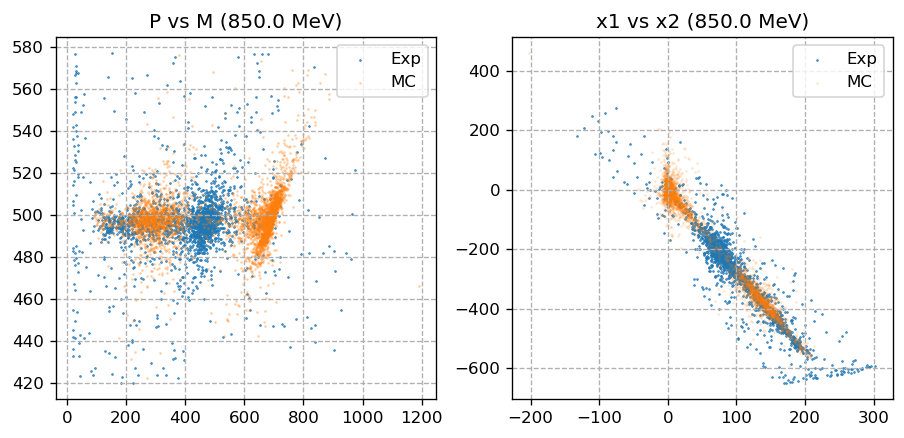

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.scatter(dfE.ksptot, dfE.ksminv, marker='.', s=1, label='Exp');
ax1.scatter(dfM.ksptot, dfM.ksminv, marker='.', s=1, alpha=0.4, label='MC');
ax1.set_title(f'P vs M ({e0} MeV)');
ax1.grid(ls='--')
ax1.legend();
# plt.plot([750, 900], [460+(750-750)*np.tan(phi), 460+(900-750)*np.tan(phi)])
# # plt.xlim(0, 250)

ax2.scatter(dfE.x1, dfE.x2, marker='.', s=1, label='Exp');
ax2.scatter(dfM.x1, dfM.x2, marker='.', s=1, alpha=0.2, label='MC');
ax2.set_title(f'x1 vs x2 ({e0} MeV)');
ax2.grid(ls='--')
ax2.legend();
# plt.ylim(-100, 300)

<AxesSubplot:>

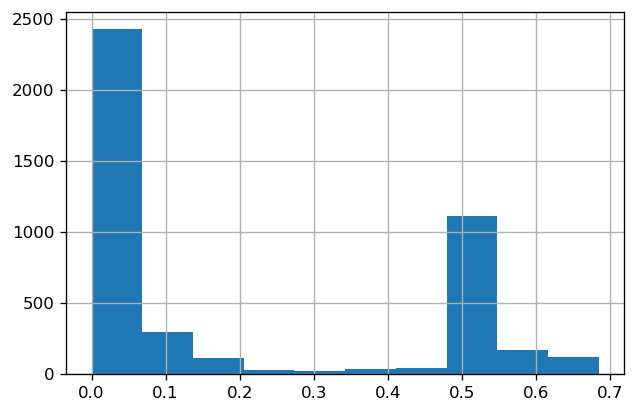

In [88]:
dfM.sim_energy.hist()

In [89]:
dfM_soft = dfM.loc[dfM.sim_energy < 0.4]
dfM_hard = dfM.loc[dfM.sim_energy >= 0.4]

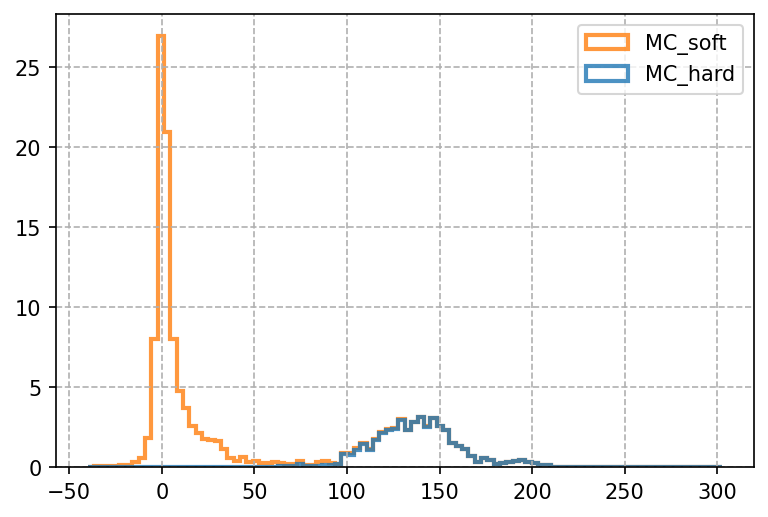

In [90]:
plt.figure(dpi=150)
plt.grid(ls='--')
hist_range, hist_bins, hist_norm = (-40, dfE.x1.max()), 100, 7

count_exp = np.count_nonzero(abs(dfE.x1)<hist_norm)
count_mc  = np.count_nonzero(abs(dfM.x1)<hist_norm)

# pys.hep_histo(dfE.x1, bins=hist_bins, range=hist_range, label='Exp')
# plt.hist(dfE.x1, bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, label='Exp', alpha=1);
# plt.hist(dfM.x1, bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, label='MC', 
#          weights=np.ones(len(dfM))*count_exp/count_mc, alpha=0.8);
plt.hist([dfM_hard.x1, dfM_soft.x1], bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, 
         label=['MC_hard', 'MC_soft'], stacked=True, alpha=0.8, zorder=0,
         weights=[np.ones(len(dfM_hard))*count_exp/count_mc, np.ones(len(dfM_soft))*count_exp/count_mc]);
# plt.yscale('log')
plt.legend();

Fit

In [91]:
import numba as nb
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL, LeastSquares
from argparse import Namespace

In [104]:
fit_range = (-40, 25)
hist_range = (-40, 160)

width = hist_range[1] - hist_range[0]
dataE, dataM = dfE.x1.values, dfM.x1.values
dataM_soft = dfM_soft.x1.values
dataM_hard = dfM_hard.x1.values

In [105]:
kwd = {"parallel": False, "fastmath": True}

@nb.njit(**kwd)
def signal_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    invnorm = 1 / ( np.sqrt(2 * np.pi) * sigma )
    signal = np.exp(-(z**2)/2) * invnorm
    return signal

@nb.njit(**kwd)
def exp_pdf(x, l):
    xmin, xmax = fit_range
    C = l/(np.exp(l*xmax) - np.exp(l*xmin))
    f = C*np.exp(l*x)
    return np.where((x>xmax)|(x<xmin), 0, f)

@nb.njit(**kwd)
def norm_pdf(x, mu1, mu2, sigma1, sigma2, f, fs, l, fn):
    sig1 = signal_pdf(x, mu1, sigma1)
    sig2 = signal_pdf(x, mu2, sigma2)
    hard = exp_pdf(x, l)
    bkg  = 1/width
    return f*( fs*(fn*sig1 + (1-fn)*sig2) + (1-fs)*hard ) + (1-f)*bkg

In [116]:
params = {
    'n': 1000, 'limit_n': (0, None),
    'mu1': 0, 'limit_mu1': (-2, 2),
    'mu2': 1, 'limit_mu2': (-12, 12),
    'sigma1': 2, 'limit_sigma1': (0,None),
    'sigma2': 5, 'limit_sigma2': (0,None),
    'f': 1, 'limit_f': (1, 1),
    'l': 0.1, 'limit_l': (-1, 1),
    'fn': 0.5, 'limit_fn': (0, 1),
    'fs': 0.5, 'limit_fs': (0, 1),
}

In [117]:
def fit_data(data, fit_range, params):
    xmin, xmax = fit_range
    data = data[(data>xmin)&(data<xmax)]
    m = Minuit(ExtendedUnbinnedNLL(data, lambda x, n, mu1, mu2, sigma1, sigma2, f, fs, l, fn: 
                               (n, n * norm_pdf(x, mu1, mu2, sigma1, sigma2, f, fs, l, fn))),
           **params
          )
    print(m.migrad())
    return m    

In [118]:
params['limit_fs'] = (1, 1)

In [119]:
m = fit_data(dataM, fit_range, params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -9666                      │       Ncalls = 300 (300 total)       │
│ EDM = 2.18e-05 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼───

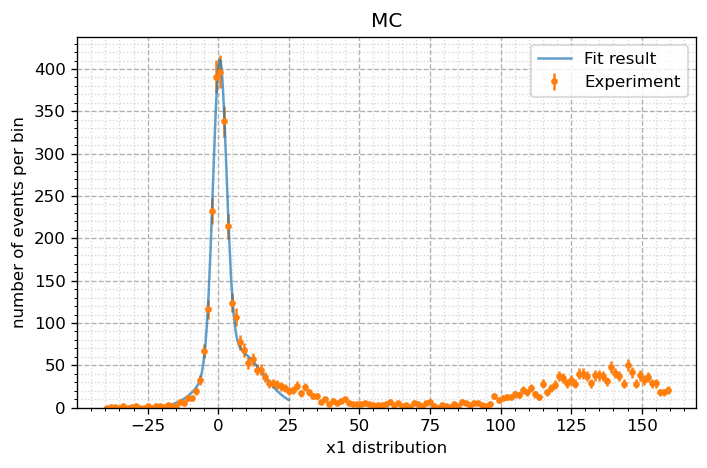

In [120]:
pys.plot_fit(dataM, norm_pdf, m, 140, hist_range, fit_range, errors=True, label='Experiment', xtitle='x1 distribution',
           ytitle='number of events per bin', title='MC', description=False)
# plt.savefig('pic3.png')

In [111]:
for key in m.values:
    params[key] = m.values[key]
    if key not in ['fn', 'mu1', 'mu2', 'sigma1', 'sigma2', 'n']:
        params[f'limit_{key}'] = (m.values[key], m.values[key])
params['limit_f'] = (0, 1)

In [112]:
m = fit_data(dataE, fit_range, params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 16.47                      │       Ncalls = 245 (245 total)       │
│ EDM = 1.11e-06 (Goal: 0.0001)    │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼───

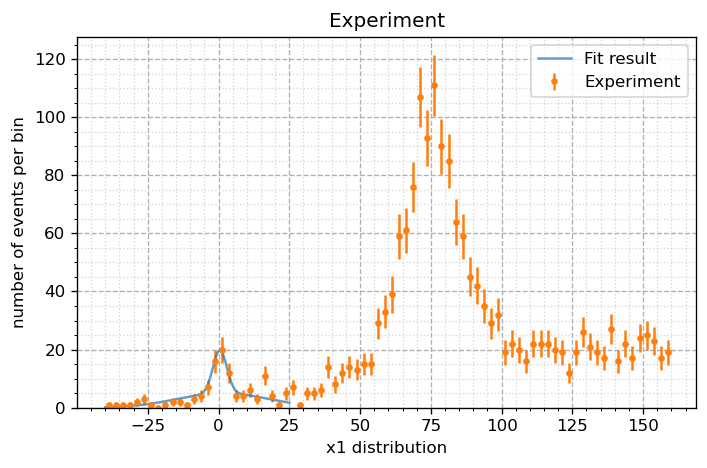

In [113]:
pys.plot_fit(dataE, norm_pdf, m, 80, hist_range, fit_range, errors=True, label='Experiment', xtitle='x1 distribution',
           ytitle='number of events per bin', title='Experiment', description=False)
# plt.savefig('pic3.png')

In [74]:
from pylib.radcors import RadCor

In [75]:
cs_approx = pd.read_csv('../data/cross_sections_kskl.txt', header=None, sep=' ')[[1, 2]]
cs_approx[1] /= 2

In [76]:
cs_approx

,1,2
0,497.5,0.000000
1,498.0,0.067593
2,498.5,0.292279
3,499.0,0.642567
4,499.5,1.128050
...,...,...
550,1046.0,0.368000
551,1047.0,0.381000
552,1048.0,0.394000
553,1049.0,0.409000


In [77]:
r = RadCor(cs_approx[1], cs_approx[2])

In [78]:
r.F_Radcor(1059.947/2)

(1.8978407634915915, 1.3592433366270849e-05)

In [44]:
np.extract(r.y>1000, r.y)

array([1009.83788297, 1042.80429893, 1074.80668805, 1105.84505034,
       1135.91938579, 1165.02969441, 1193.1759762 , 1220.35823115,
       1246.57645926, 1271.10635807, 1291.33171835, 1307.01606621,
       1318.15940165, 1324.76172467, 1326.82303528, 1324.34333347,
       1317.32261923, 1305.76089258, 1289.65815351, 1269.01440203,
       1243.82963812, 1214.10386179, 1179.83707305, 1141.02927189,
       1097.68045831, 1049.79063231])

In [45]:
np.extract(r.y>1000, r.x)

array([509.02958296, 509.08582858, 509.14207421, 509.19831983,
       509.25456546, 509.31081108, 509.36705671, 509.42330233,
       509.47954795, 509.53579358, 509.5920392 , 509.64828483,
       509.70453045, 509.76077608, 509.8170217 , 509.87326733,
       509.92951295, 509.98575858, 510.0420042 , 510.09824982,
       510.15449545, 510.21074107, 510.2669867 , 510.32323232,
       510.37947795, 510.43572357])

In [10]:
# dfExp = uproot.open('../trees/exp2019.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj.root')['t'].pandas.df()

In [8]:
dfExp = uproot.open('../trees/exp2019_runs.root')['t'].pandas.df()


In [11]:
dfMC

,ebeam,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,name
entry,,,,,,,,,,,,,,,,,,,,,
0,537.453979,0,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,...,1.170788,0.991979,0.694018,20,9,499.395172,216.374481,0.999027,2.772172,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
1,537.453979,0,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,...,0.386262,0.529379,2.069548,20,13,505.448303,115.481873,0.993188,1.221455,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
2,537.453979,0,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,...,1.026735,0.957598,2.091434,21,16,497.253052,201.719330,0.996737,0.513309,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
3,537.453979,0,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,...,0.688015,1.209268,1.051637,16,17,497.766693,194.066284,0.999999,0.949363,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
4,537.453979,0,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,...,0.258133,0.670550,1.641627,15,11,496.693756,116.323097,0.992242,0.680561,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180964,987.804504,0,987.804504,0,2.296050,2.302264,-3.326244,-2.858969,217.647888,326.898590,...,1.985037,0.435221,0.937301,8,9,488.565735,378.995667,0.985185,2.075993,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180965,987.804504,0,987.804504,2,1.565175,2.376279,3.020628,4.328830,392.622803,558.588196,...,0.396961,0.814028,2.583056,18,13,502.476227,851.478271,0.999599,0.804988,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180966,987.804504,0,987.804504,3,1.524234,1.348975,4.602494,5.106483,106.665916,370.123230,...,0.786073,0.843128,0.852886,22,17,425.076477,383.258636,0.935170,0.304142,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
